In [ ]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array, argmax, random, take
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector,GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras import optimizers
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import string
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json

def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Load each line as a JSON object
            json_object = json.loads(line)
            data.append(json_object)
    return data
# Example usage
file_path = '/content/drive/MyDrive/BanglaNMT/train.jsonl'
test="/content/drive/MyDrive/BanglaNMT/test.jsonl"
jsonl_data = read_jsonl_file(file_path)
jsonl_test=read_jsonl_file(test)

In [ ]:
data=[list(item.values()) for item in jsonl_data[:850000]]

In [ ]:
data1=[list(item.values()) for item in jsonl_test]

#data showing

In [ ]:
data

[['আমাকে সব কিছু জানাও', 'Just keep me informed.'],
 ['"এ্যামোর এন্ড সাইকি", এটা খারাপ, মনিব এটায় প্রচুর পরিমাণে চিরহরিৎ (একপ্রকার সুগন্ধী লতা) আছে আর প্রচুর পরিমাণে...',
  'It\'s bad, "Amor and Psyche" is, master.'],
 ['কাছানো', 'Overtake'],
 ['পাকিস্তানের জাতীয় পতাকা', 'Flag of Pakistan'],
 ['দন্তোদ্গম', 'cutting of teeth'],
 ['জোসেফের ভাইয়েরা তাকে বিশ শেকেল, অর্থাৎ ১৬৬ গ্রাম রূপার বিনিময়ে বেচে দিয়েছিলো ইসমায়েলিদের কাছে।',
  'twenty silver shekels, or rather 166 grams of silver (the same price as a slave'],
 ['গাছি [ছবি: মনিরুল এইচ খান]', 'Gachhi [Courtesy: M Monirul H Khan]'],
 ['ইশ', 'etc'],
 ['(১ তীমথিয় ১:১৩) কিন্তু তিনি পরিবর্তিত হয়েছিলেন!',
  '(1 Timothy 1:13) But he changed!'],
 ['স্যামসাং ফায়ার এন্ড মেরিন বীমা.', 'Samsung Fire &amp; Marine Insurance.'],
 ['পূর্ব বাংলার জমিদারি প্রথা বিলুপ্তি (১৯৫০) ও ভাষা আন্দোলন তাঁর আমলের উল্লেখযোগ্য ঘটনা।',
  'The abolition of the Zamindari system in East Bengal (1950) and the language movement were two most important events during his tenu

# saparate Bangli and English

In [ ]:
Bangli=[]
English=[]
def function(data):
  for i in range(len(data)):
     Bangli.append(data[i][0])
     English.append(data[i][1])


In [ ]:
test=function(data)

#Convert to dataFrame

In [ ]:
dat = {"English": English, 'Bangli': Bangli}
dataset = pd.DataFrame(dat)

In [ ]:
dataset.head()

,English,Bangli
0,Just keep me informed.,আমাকে সব কিছু জানাও
1,"It's bad, ""Amor and Psyche"" is, master.","""এ্যামোর এন্ড সাইকি"", এটা খারাপ, মনিব এটায় প্র..."
2,Overtake,কাছানো
3,Flag of Pakistan,পাকিস্তানের জাতীয় পতাকা
4,cutting of teeth,দন্তোদ্গম


#preprocessing

In [ ]:

def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()#convert to lowercase

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789:":
        string = string.replace(p," ")

    string = re.sub('\s+',' ', string)
    string = string.strip() # Join to word

    return string
dataset["English"] = dataset["English"].apply(lambda x: clean(x))

In [ ]:
english_stopwords = set(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't",
    'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
    "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during',
    'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't",
    'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn',
    "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn',
    "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
    'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should',
    "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them',
    'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very',
    'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why',
    'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
    'yourself', 'yourselves'])
def Epreprocess_text(text):
    text = ' '.join([word for word in text.split() if word not in english_stopwords])#remove to bangla word
    return text
dataset['English'] = dataset['English'].apply(Epreprocess_text)

In [ ]:
stopword=['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত',
          'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার',
          'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা',
          'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্',
          'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন',
          'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে',
          'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে',
          'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন',
          'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু',
          'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও', 'কোনো', 'ক্ষেত্রে',
          'কয়েক', 'খুব', 'গিয়ে', 'গিয়েছে', 'গিয়ে', 'গুলি', 'গেছে', 'গেল', 'গেলে', 'গোটা', 'চলে', 'চান', 'চায়', 'চার', 'চালু',
          'চেয়ে', 'চেষ্টা', 'ছাড়া', 'ছাড়াও', 'ছিল', 'ছিলেন', 'জন', 'জনকে', 'জনের', 'জন্য', 'জন্যওজে', 'জানতে', 'জানা', 'জানানো',
          'জানায়', 'জানিয়ে', 'জানিয়েছে', 'জে', 'জ্নজন', 'টি', 'ঠিক', 'তখন', 'তত', 'তথা', 'তবু', 'তবে', 'তা', 'তাঁকে', 'তাঁদের', 'তাঁর',
          'তাঁরা', 'তাঁাহারা', 'তাই', 'তাও', 'তাকে', 'তাতে', 'তাদের', 'তার', 'তারপর', 'তারা', 'তারৈ', 'তাহলে', 'তাহা', 'তাহাতে', 'তাহার', 'তিনঐ',
          'তিনি', 'তিনিও', 'তুমি', 'তুলে', 'তেমন', 'তো', 'তোমার', 'থাকবে', 'থাকবেন', 'থাকা', 'থাকায়', 'থাকে', 'থাকেন', 'থেকে', 'থেকেই', 'থেকেও',
          'দিকে', 'দিতে', 'দিন', 'দিয়ে', 'দিয়েছে', 'দিয়েছেন', 'দিলেন', 'দু', 'দুই', 'দুটি', 'দুটো', 'দেওয়া', 'দেওয়ার', 'দেওয়া', 'দেখতে', 'দেখা', 'দেখে',
          'দেন', 'দেয়', 'দ্বারা', 'ধরা', 'ধরে', 'ধামার', 'নতুন', 'নয়', 'না', 'নাই', 'নাকি', 'নাগাদ', 'নানা', 'নিজে', 'নিজেই', 'নিজেদের', 'নিজের',
          'নিতে', 'নিয়ে', 'নিয়ে', 'নেই', 'নেওয়া', 'নেওয়ার', 'নেওয়া', 'নয়', 'পক্ষে', 'পর', 'পরে', 'পরেই', 'পরেও', 'পর্যন্ত', 'পাওয়া', 'পাচ', 'পারি',
          'পারে', 'পারেন', 'পি', 'পেয়ে', 'পেয়্র্', 'প্রতি', 'প্রথম', 'প্রভৃতি', 'প্রযন্ত', 'প্রাথমিক', 'প্রায়', 'প্রায়', 'ফলে', 'ফিরে', 'ফের', 'বক্তব্য', 'বদলে',
          'বন', 'বরং', 'বলতে', 'বলল', 'বললেন', 'বলা', 'বলে', 'বলেছেন', 'বলেন', 'বসে', 'বহু', 'বা', 'বাদে', 'বার', 'বি', 'বিনা', 'বিভিন্ন', 'বিশেষ',
          'বিষয়টি', 'বেশ', 'বেশি', 'ব্যবহার', 'ব্যাপারে', 'ভাবে', 'ভাবেই', 'মতো', 'মতোই', 'মধ্যভাগে', 'মধ্যে', 'মধ্যেই', 'মধ্যেও', 'মনে', 'মাত্র', 'মাধ্যমে',
          'মোট', 'মোটেই', 'যখন', 'যত', 'যতটা', 'যথেষ্ট', 'যদি', 'যদিও', 'যা', 'যাঁর', 'যাঁরা', 'যাওয়া', 'যাওয়ার', 'যাওয়া', 'যাকে', 'যাচ্ছে', 'যাতে',
          'যাদের', 'যান', 'যাবে', 'যায়', 'যার', 'যারা', 'যিনি', 'যে', 'যেখানে', 'যেতে', 'যেন', 'যেমন', 'র', 'রকম', 'রয়েছে', 'রাখা', 'রেখে', 'লক্ষ',
          'শুধু', 'শুরু', 'সঙ্গে', 'সঙ্গেও', 'সব', 'সবার', 'সমস্ত', 'সম্প্রতি', 'সহ', 'সহিত', 'সাধারণ', 'সামনে', 'সি', 'সুতরাং', 'সে', 'সেই', 'সেখান',
          'সেখানে', 'সেটা', 'সেটাই', 'সেটাও', 'সেটি', 'স্পষ্ট', 'স্বয়ং', 'হইতে', 'হইবে', 'হইয়া', 'হওয়া', 'হওয়ায়', 'হওয়ার', 'হচ্ছে', 'হত', 'হতে',
          'হতেই', 'হন', 'হবে', 'হবেন', 'হয়', 'হয়তো', 'হয়নি', 'হয়ে', 'হয়েই', 'হয়েছিল', 'হয়েছে', 'হয়েছেন', 'হল', 'হলে', 'হলেই', 'হলেও', 'হলো',
          'হাজার', 'হিসাবে', 'হৈলে', 'হোক', 'হয়']

def preprocess_text(text):
    text = re.sub(r'[\|৷ʼ।,৺],EROero৳০১২৩৪৫৬৭৮৯012–34567•89[a-zA-Z0-9]+', '', text) #remove to number and Alphabate
    text = ' '.join([word for word in text.split() if word not in stopword])#remove to bangla word
    return text

# Applying preprocessing to the entire 'Bangli' column
dataset['Bangli'] = dataset['Bangli'].apply(preprocess_text)

#train test split

In [ ]:

dataset = dataset.values
# split into train/test
from sklearn.model_selection import train_test_split
train,test=train_test_split(dataset, test_size=0.2, random_state=42)

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str ="English","Bangli"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [ ]:
pd.DataFrame(dataset[100:101])

,0,1
0,strengthens keep going day see timo,"এগিয়ে চলার শক্তি প্রদান করছে, টিমোকে পারব।"""


#tokenization

In [ ]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X

def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# Prepare target tokenizer
bleu_test_avg,bleu_train_avg=
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')

# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (Bangli) Vocabulary Size: 7392

Target (Bangli) Max Length: 145


Source (English) Vocabulary Size: 10123

Source (English) Max Length: 176


#model representaion

In [ ]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX,
          trainY,
          epochs=500,
          batch_size=64,
          validation_split=0.1,
          verbose=1,
          # callbacks=[
                    #     EarlyStopping(
                    #     monitor='val_loss',
                    #     patience=10,
                    #     restore_best_weights=True
                    # )
            # ]
    )

Epoch 1/500
29/29 [==============================] - 19s 458ms/step - loss: 4.1475 - accuracy: 0.9178 - val_loss: 0.6533 - val_accuracy: 0.9520
Epoch 2/500
29/29 [==============================] - 9s 315ms/step - loss: 0.6319 - accuracy: 0.9518 - val_loss: 0.5305 - val_accuracy: 0.9520
Epoch 3/500
29/29 [==============================] - 9s 309ms/step - loss: 0.5302 - accuracy: 0.9486 - val_loss: 0.4941 - val_accuracy: 0.9520
Epoch 4/500
29/29 [==============================] - 9s 309ms/step - loss: 0.5670 - accuracy: 0.9431 - val_loss: 0.4927 - val_accuracy: 0.9520
Epoch 5/500
29/29 [==============================] - 9s 304ms/step - loss: 0.7260 - accuracy: 0.9266 - val_loss: 0.6702 - val_accuracy: 0.9336
Epoch 6/500
29/29 [==============================] - 8s 271ms/step - loss: 1.0137 - accuracy: 0.8921 - val_loss: 0.6977 - val_accuracy: 0.9290
Epoch 7/500
29/29 [==============================] - 8s 270ms/step - loss: 1.3606 - accuracy: 0.8494 - val_loss: 0.8616 - val_accuracy: 0.910

#accuracy curve

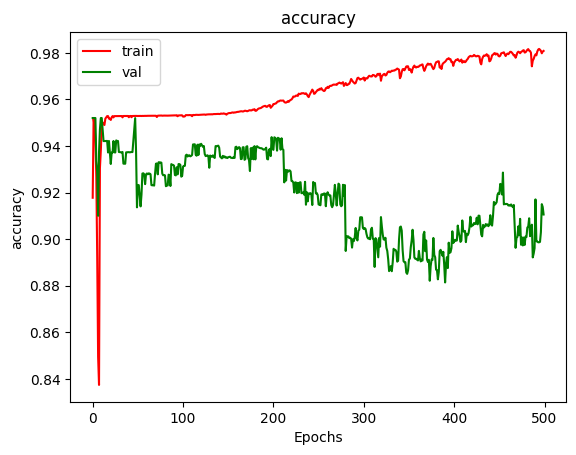

In [ ]:
plt.plot(history.history["accuracy"],c="red")
plt.plot(history.history["val_accuracy"],c="green")
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(['train','val'])
plt.show()

#loss curve

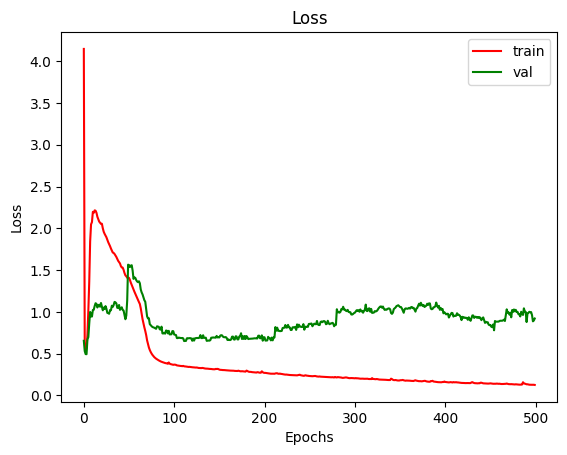

In [ ]:
plt.plot(history.history["loss"],c="red")
plt.plot(history.history["val_loss"],c="green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train','val'])
plt.show()

Test evaluation

In [ ]:
from sklearn.metrics import accuracy_score
model.evaluate(testX,testY)

16/16 [==============================] - 1s 58ms/step - loss: 0.7701 - accuracy: 0.9299


[0.7700855135917664, 0.9298758506774902]

#prediction

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [ ]:


def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')

    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break

# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
ENGLISH (SOURCE)               BANGLI (TARGET)           AUTOMATIC TRANSLATION IN BANGLI

বাস্তবায়নে দু'টি গুরুত্বপূর্ণ বিষয় হলো: অবকাঠামোগত আবশ্যকতা মেটানো প্রয়োজনীয়সংখ্যক উপযুক্ত শিক্ষকের ব্যবস্থা করা। two significant concerns realize need infrastructural development recruitment adequate number qualified teachers two significant concerns realize need infrastructural development recruitment adequate number qualified teachers
অন্ধকার গহ্বর এসেছি আমি।       returned abyss            
কবিরা নাটক লিখতেন, নৃত্যও অন্তর্ভুক্ত (যেমন ইউরিপিডিস)। poets wrote plays cases incorporated dance see euripides poets wrote wrote cases incorporated dance see euripides
সুব্যক্ত                       well developed            well developed
আখতারুজ্জামান ইলিয়াস           akhtaruzzaman elias       akhtaruzzaman elias
(১ করি. ১৬:১৩) ঘটতে চাই না।    cor prevent happening us  cor prevent happening us
বাংলাদেশের বঙ্গীয় অববাহিকা উত্তরে পূর্ব হিমালয় পূর্বে ইন্দো-বার্মা শ্রেণীমাল

#Bleu score

In [ ]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    avg=
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu_dic

# Compute the BLEU Score



In [ ]:
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

In [ ]:
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)

In [ ]:
bleu_test

{'1-grams': 0.42010538515212464,
 '1-2-grams': 0.319977130103728,
 '1-3-grams': 0.21672877518274,
 '1-4-grams': 0.15243964379341}

In [ ]:
bleu_test_avg=(0.42010538515212464+0.319977130103728+0.21672877518274+0.15243964379341)/4
bleu_test_avg

0.2773127335580007

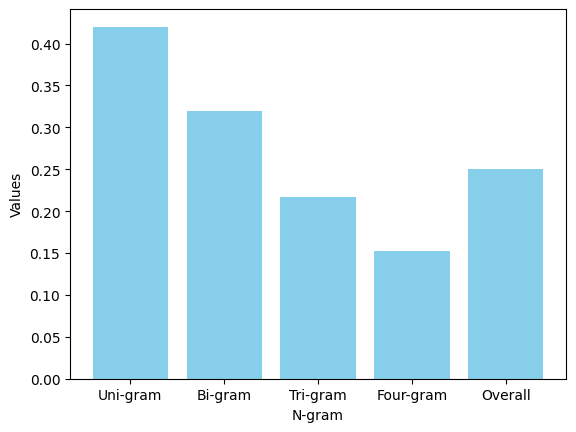

In [ ]:
import matplotlib.pyplot as plt

n_grams = ['Uni-gram', 'Bi-gram', 'Tri-gram', 'Four-gram','Overall']
values = [0.42010538515212464, 0.319977130103728, 0.21672877518274, 0.15243964379341, 0.25]

plt.bar(n_grams, values,color='skyblue')
#plt.title('N-gram Score')
plt.xlabel('N-gram')
plt.ylabel('Values')
plt.show()


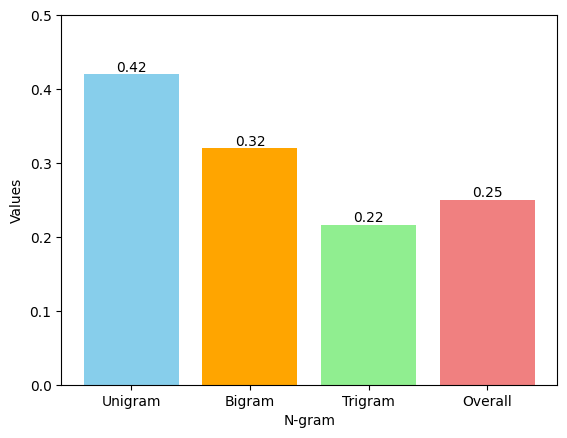

In [ ]:
import matplotlib.pyplot as plt

n_grams = ['Unigram', 'Bigram', 'Trigram', 'Overall']
values = [0.42010538515212464, 0.319977130103728, 0.21672877518274, 0.25]

# Define colors for each bar
colors = ['skyblue', 'orange', 'lightgreen', 'lightcoral']

plt.bar(n_grams, values, color=colors)
plt.xlabel('N-gram')
plt.ylabel('Values')

# Add value labels on top of each bar
for i in range(len(n_grams)):
    plt.text(i, values[i], round(values[i], 2), ha='center', va='bottom')

# Set y-axis limit from 0 to 0.5
plt.ylim(0, 0.5)

plt.show()


In [ ]:
bleu_train

{'1-grams': 0.5514187340878222,
 '1-2-grams': 0.49668275247329996,
 '1-3-grams': 0.47887783335843687,
 '1-4-grams': 0.40908895901799924}

In [ ]:
import math

# Define the values
values = [0.42010538515212464, 0.319977130103728, 0.21672877518274, 0.15243964379341]

# Calculate the geometric mean
geometric_mean = math.exp(sum(map(math.log, values)) / len(values))

print("Geometric Mean:", geometric_mean)


Geometric Mean: 0.25815047134872954


In [ ]:
bleu_train_avg=(0.5514187340878222+0.49668275247329996+0.47887783335843687+0.40908895901799924)/4
bleu_train_avg

0.4840170697343895

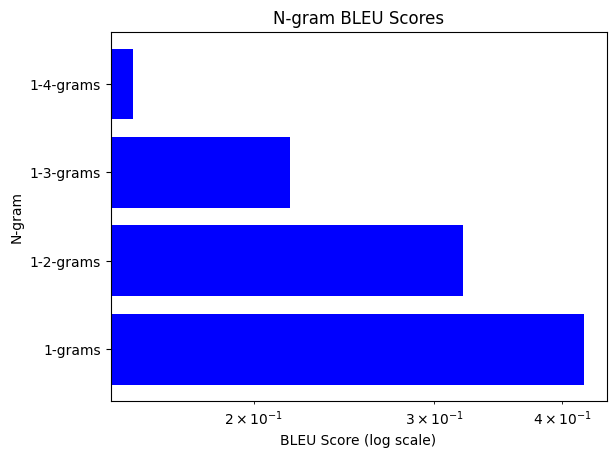

In [ ]:
import matplotlib.pyplot as plt

# Given BLEU scores

# Plotting
fig, ax = plt.subplots()

ngram_labels = list(bleu_test.keys())
scores = list(bleu_test.values())

ax.barh(ngram_labels, scores, color='blue')
ax.set_xscale('log')  # Use log scale for better visualization

# Add labels and title
ax.set_xlabel('BLEU Score (log scale)')
ax.set_ylabel('N-gram')
ax.set_title('N-gram BLEU Scores')

plt.show()


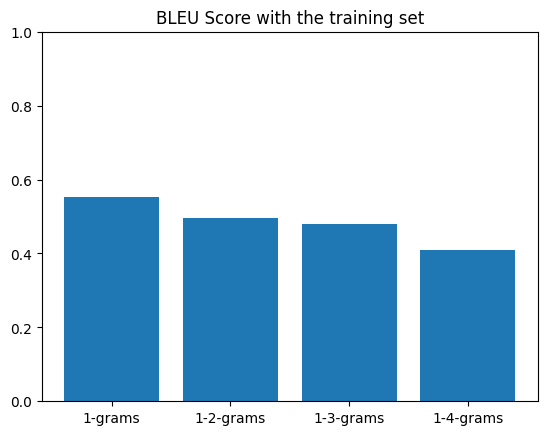

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

# Test chatgpt

In [ ]:
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
data=read_text("/content/drive/MyDrive/chatgpt_response/Save_Bangla_response.txt")
ben_eng = to_lines(data)
ben_eng = list(ben_eng)



In [ ]:
import pandas as pd

# Initialize lists to store English and Bangla responses
english_data = []
bangla_data = []

# Parse the data and separate English and Bangla responses
for item in ben_eng:
    text = item[0]
    if text.startswith('English'):
        english_data.append(text.split('English ')[-1])
        bangla_data.append('')
    elif text.startswith('GPT Bangla'):
        english_data.append('')
        bangla_data.append(text.split('GPT Bangla Response: ')[-1])

# Create a DataFrame
df = pd.DataFrame({'English': english_data, 'Bangla': bangla_data})

# Display the DataFrame
print(df)


                                                English  \
0                                                 data:   
1                                                         
2     2: 1. Bangladesh High Commissioner to the Unit...   
3                                                         
4     3: 2. The terrorists have no race, religion an...   
...                                                 ...   
1997                                                      
1998  1000: 999. The Bangladesh embassy in South Kor...   
1999                                                      
2000  1001: 1000. We've agreed to explore all possib...   
2001                                                      

                                                 Bangla  
0                                                        
1                                        ইংরেজি উপাত্ত:  
2                                                        
3     ১। যুক্তরাজ্যের বাংলাদেশ উচ্চায়িত কমিশনার সায...  
4

In [ ]:

eng=df['English']
bng=df['Bangla']

In [ ]:
eng = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng]
bng = [s.translate(str.maketrans('', '', string.punctuation)) for s in bng]

Make DataFrame

In [ ]:
dataset= pd.DataFrame({'English': eng, 'Bangli': bng})
dataset

,English,Bangli
0,data,
1,,ইংরেজি উপাত্ত
2,2 1 Bangladesh High Commissioner to the United...,
3,,১। যুক্তরাজ্যের বাংলাদেশ উচ্চায়িত কমিশনার সায...
4,3 2 The terrorists have no race religion and c...,
...,...,...
1997,,998। এই প্রসঙ্গে প্রধানমন্ত্রী বলেছেন বঙ্গবন্ধ...
1998,1000 999 The Bangladesh embassy in South Korea...,
1999,,৯৯৯। শনিবারে বাংলাদেশ এম্বাসিতে দফা প্রকাশ করে...
2000,1001 1000 Weve agreed to explore all possible ...,


In [ ]:
stopword=['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত',
          'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার',
          'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা',
          'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্',
          'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন',
          'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে',
          'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে',
          'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন',
          'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু',
          'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও', 'কোনো', 'ক্ষেত্রে',
          'কয়েক', 'খুব', 'গিয়ে', 'গিয়েছে', 'গিয়ে', 'গুলি', 'গেছে', 'গেল', 'গেলে', 'গোটা', 'চলে', 'চান', 'চায়', 'চার', 'চালু',
          'চেয়ে', 'চেষ্টা', 'ছাড়া', 'ছাড়াও', 'ছিল', 'ছিলেন', 'জন', 'জনকে', 'জনের', 'জন্য', 'জন্যওজে', 'জানতে', 'জানা', 'জানানো',
          'জানায়', 'জানিয়ে', 'জানিয়েছে', 'জে', 'জ্নজন', 'টি', 'ঠিক', 'তখন', 'তত', 'তথা', 'তবু', 'তবে', 'তা', 'তাঁকে', 'তাঁদের', 'তাঁর',
          'তাঁরা', 'তাঁাহারা', 'তাই', 'তাও', 'তাকে', 'তাতে', 'তাদের', 'তার', 'তারপর', 'তারা', 'তারৈ', 'তাহলে', 'তাহা', 'তাহাতে', 'তাহার', 'তিনঐ',
          'তিনি', 'তিনিও', 'তুমি', 'তুলে', 'তেমন', 'তো', 'তোমার', 'থাকবে', 'থাকবেন', 'থাকা', 'থাকায়', 'থাকে', 'থাকেন', 'থেকে', 'থেকেই', 'থেকেও',
          'দিকে', 'দিতে', 'দিন', 'দিয়ে', 'দিয়েছে', 'দিয়েছেন', 'দিলেন', 'দু', 'দুই', 'দুটি', 'দুটো', 'দেওয়া', 'দেওয়ার', 'দেওয়া', 'দেখতে', 'দেখা', 'দেখে',
          'দেন', 'দেয়', 'দ্বারা', 'ধরা', 'ধরে', 'ধামার', 'নতুন', 'নয়', 'না', 'নাই', 'নাকি', 'নাগাদ', 'নানা', 'নিজে', 'নিজেই', 'নিজেদের', 'নিজের',
          'নিতে', 'নিয়ে', 'নিয়ে', 'নেই', 'নেওয়া', 'নেওয়ার', 'নেওয়া', 'নয়', 'পক্ষে', 'পর', 'পরে', 'পরেই', 'পরেও', 'পর্যন্ত', 'পাওয়া', 'পাচ', 'পারি',
          'পারে', 'পারেন', 'পি', 'পেয়ে', 'পেয়্র্', 'প্রতি', 'প্রথম', 'প্রভৃতি', 'প্রযন্ত', 'প্রাথমিক', 'প্রায়', 'প্রায়', 'ফলে', 'ফিরে', 'ফের', 'বক্তব্য', 'বদলে',
          'বন', 'বরং', 'বলতে', 'বলল', 'বললেন', 'বলা', 'বলে', 'বলেছেন', 'বলেন', 'বসে', 'বহু', 'বা', 'বাদে', 'বার', 'বি', 'বিনা', 'বিভিন্ন', 'বিশেষ',
          'বিষয়টি', 'বেশ', 'বেশি', 'ব্যবহার', 'ব্যাপারে', 'ভাবে', 'ভাবেই', 'মতো', 'মতোই', 'মধ্যভাগে', 'মধ্যে', 'মধ্যেই', 'মধ্যেও', 'মনে', 'মাত্র', 'মাধ্যমে',
          'মোট', 'মোটেই', 'যখন', 'যত', 'যতটা', 'যথেষ্ট', 'যদি', 'যদিও', 'যা', 'যাঁর', 'যাঁরা', 'যাওয়া', 'যাওয়ার', 'যাওয়া', 'যাকে', 'যাচ্ছে', 'যাতে',
          'যাদের', 'যান', 'যাবে', 'যায়', 'যার', 'যারা', 'যিনি', 'যে', 'যেখানে', 'যেতে', 'যেন', 'যেমন', 'র', 'রকম', 'রয়েছে', 'রাখা', 'রেখে', 'লক্ষ',
          'শুধু', 'শুরু', 'সঙ্গে', 'সঙ্গেও', 'সব', 'সবার', 'সমস্ত', 'সম্প্রতি', 'সহ', 'সহিত', 'সাধারণ', 'সামনে', 'সি', 'সুতরাং', 'সে', 'সেই', 'সেখান',
          'সেখানে', 'সেটা', 'সেটাই', 'সেটাও', 'সেটি', 'স্পষ্ট', 'স্বয়ং', 'হইতে', 'হইবে', 'হইয়া', 'হওয়া', 'হওয়ায়', 'হওয়ার', 'হচ্ছে', 'হত', 'হতে',
          'হতেই', 'হন', 'হবে', 'হবেন', 'হয়', 'হয়তো', 'হয়নি', 'হয়ে', 'হয়েই', 'হয়েছিল', 'হয়েছে', 'হয়েছেন', 'হল', 'হলে', 'হলেই', 'হলেও', 'হলো',
          'হাজার', 'হিসাবে', 'হৈলে', 'হোক', 'হয়']

def preprocess_text(text):
    text = re.sub(r'[\|৷ʼ।,৺],EROero৳০১২৩৪৫৬৭৮৯012–34567•89[a-zA-Z0-9]+', '', text) #remove to number and Alphabate
    text = ' '.join([word for word in text.split() if word not in stopword])#remove to bangla word
    return text

# Applying preprocessing to the entire 'Bangli' column
dataset['Bangli'] = dataset['Bangli'].apply(preprocess_text)

In [ ]:

def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()#convert to lowercase

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789:":
        string = string.replace(p," ")

    string = re.sub('\s+',' ', string)
    string = string.strip() # Join to word

    return string
dataset["English"] = dataset["English"].apply(lambda x: clean(x))

In [ ]:
english_stopwords = set(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't",
    'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
    "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during',
    'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't",
    'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn',
    "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn',
    "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
    'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should',
    "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them',
    'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very',
    'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why',
    'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
    'yourself', 'yourselves'])
def Epreprocess_text(text):
    text = ' '.join([word for word in text.split() if word not in english_stopwords])#remove to bangla word
    return text
dataset['English'] = dataset['English'].apply(Epreprocess_text)

In [ ]:

dataset = dataset.values
# split into train/test
from sklearn.model_selection import train_test_split
train,test=train_test_split(dataset, test_size=0.01, random_state=42)

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str ="English","Bangli"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

Token

In [ ]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X

def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')

# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (Bangli) Vocabulary Size: 3371

Target (Bangli) Max Length: 27


Source (English) Vocabulary Size: 5404

Source (English) Max Length: 448


Prediction

In [ ]:
pred=model.predict(testX)
pred

1/1 [==============================] - 2s 2s/step


array([[[4.8746562e-04, 6.2190937e-03, 2.5680590e-02, ...,
         6.3879156e-07, 1.8180693e-07, 1.8340072e-07],
        [1.2431791e-03, 1.0052341e-01, 1.7375076e-02, ...,
         2.4849842e-06, 1.7581142e-08, 1.1344226e-08],
        [1.3350559e-03, 1.9800643e-02, 5.0881844e-02, ...,
         1.2910747e-03, 3.2543976e-08, 2.0085052e-08],
        ...,
        [9.9186605e-01, 4.5788420e-06, 6.4839805e-05, ...,
         2.9708814e-17, 5.7205743e-13, 1.2408197e-12],
        [9.9586427e-01, 3.2866103e-06, 1.9484729e-04, ...,
         2.7823444e-17, 4.0085536e-14, 3.3537742e-13],
        [9.9732709e-01, 4.8877459e-06, 9.9430373e-04, ...,
         9.0579281e-17, 8.0930014e-14, 3.0829005e-12]],

       [[1.0000000e+00, 6.5816419e-09, 3.4099500e-08, ...,
         3.6293363e-25, 5.5574285e-19, 5.1750761e-19],
        [9.9999952e-01, 1.0119298e-08, 8.7007521e-08, ...,
         3.2738611e-22, 1.8859161e-16, 1.5585793e-15],
        [1.0000000e+00, 4.4778214e-10, 3.5667449e-09, ...,
         2.098

Test evalution

In [ ]:
model.evaluate(testX,testY)

1/1 [==============================] - 0s 99ms/step - loss: 2.7528 - accuracy: 0.7601


[2.7527620792388916, 0.7601410746574402]

Chat GPT Response Bleu score

In [ ]:
bleu_test = bleu_score(model, tar_tokenizer,testX, train)

In [ ]:
bleu_test

{'1-grams': 0.24179543336133083,
 '1-2-grams': 0.1446858985617725,
 '1-3-grams': 0.09350104195323913,
 '1-4-grams': 0.08602255523374168}

In [ ]:
avg

0.19324066596155165

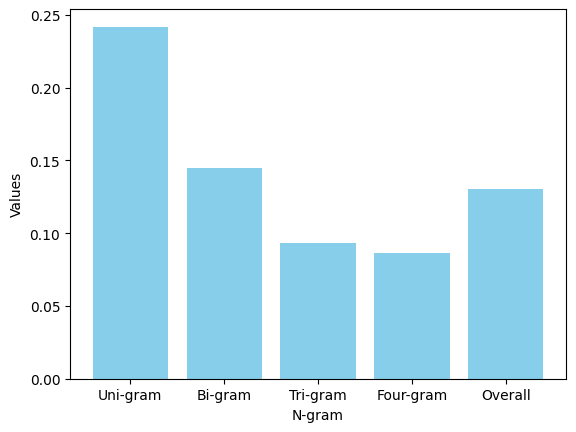

In [ ]:
import matplotlib.pyplot as plt

n_grams = ['Uni-gram', 'Bi-gram', 'Tri-gram', 'Four-gram','Overall']
values = [0.24179543336133083, 0.1446858985617725,.09350104195323913, 0.08602255523374168, 0.13]

plt.bar(n_grams, values,color='skyblue')
#plt.title('N-gram Score')
plt.xlabel('N-gram')
plt.ylabel('Values')
plt.show()

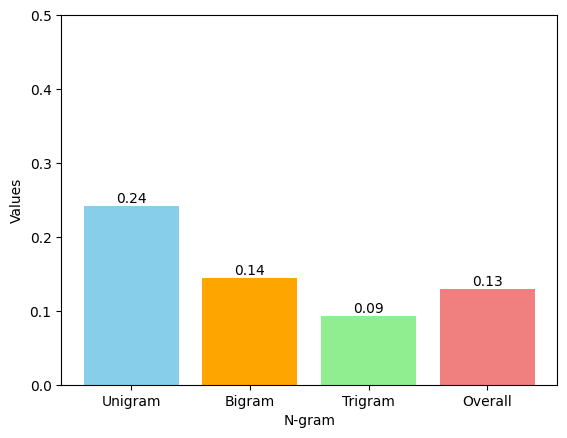

In [ ]:
import matplotlib.pyplot as plt

n_grams = ['Unigram', 'Bigram', 'Trigram','Overall']
values = [0.24179543336133083, 0.1446858985617725, 0.09350104195323913, 0.13]

# Define colors for each bar
colors = ['skyblue', 'orange', 'lightgreen', 'lightcoral']

plt.bar(n_grams, values, color=colors)
plt.xlabel('N-gram')
plt.ylabel('Values')

# Add value labels on top of each bar
for i in range(len(n_grams)):
    plt.text(i, values[i], round(values[i], 2), ha='center', va='bottom')

# Set y-axis limit from 0 to 0.5
plt.ylim(0, 0.5)

plt.show()


In [ ]:
# import nltk
# from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


# references = ['Bangladesh High Commissioner to the United Kingdom Saida Muna Tasneen and senior officials of Bangladesh Mission in London saw him off at the airport.']

# candidates = ['যুক্তরাজ্যের বাংলাদেশ উচ্চায়িত কমিশনার সায়েদা মুনা তাসনীন এবং লন্ডনের বাংলাদেশ মিশনের উচ্চপদস্থ কর্মকর্তাগণ তাকে বিমানবন্দরে দেখে দিলেন।']

# # Calculate BLEU score for a single sentence
# bleu_single = sentence_bleu(references[0], candidates[0])
# print(f'BLEU Score (Single Sentence): {bleu_single}')

# # Calculate BLEU score for multiple sentences (corpus)
# bleu_corpus = corpus_bleu(references, candidates)
# print(f'BLEU Score (Corpus): {bleu_corpus}')

BLEU Score (Single Sentence): 5.315431820564006e-232
BLEU Score (Corpus): 5.315431820564006e-232
